In [1]:
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn
import os
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

import onnx
import onnxscript

<table>
    <tr>
        <th>Problem Statement</th>
        <th>Hidden Layer</th>
        <th>Output Layer</th>
        <th>Loss Function</th>
    </tr>
    <tr>
        <td>Regression</td>
        <td>ReLU</td>
        <td>Linear</td>
        <td>MSE/MAE/Kuber</td>
    </tr>
    <tr>
        <td>Binary Classification</td>
        <td>ReLU</td>
        <td>Sigmoid</td>
        <td>Binary Cross Entropy</td>
    </tr>
    <tr>
        <td>Multiclass Classification</td>
        <td>ReLU</td>
        <td>Softmax</td>
        <td>Categorical/Sparse Cross Entropy</td>
    </tr>
</table>

## A Simple Neural Network

In [ ]:
x1 = torch.randint(1, 100, (100,)) #min, max, size
x2 = torch.randint(1, 100, (100,))

y = (2*x2+5*x1) # we need to find this formula
#y = [(torch.square(y))*111 for y in y] 

data = {'Feature 1': x1, 'Feature 2': x2, 'Label': y}
df = pd.DataFrame(data)

print(df)
print(df.describe())


In [ ]:
#loc[#Rows, #Columns], loc is label-based
#iloc[:, index], iloc is integer-based

#print(df.loc[0]) # Gives the entire row

#Fetch row as well as columns
# print(df.loc[0:5, "Feature 2"])

print(f" Feature 1: {df.iloc[0, 0]}")
print(f" Feature 2: {df.iloc[0, 1]}")

# Train, Validate, Test split

# train_data = df.iloc[0:60, :]
# # print(train_data)
# validate_data = df.iloc[60:80, :]
# test_data = df.iloc[80:100, :]


In [14]:
# Custom Dataset class
class DataFrameDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.features = torch.tensor(dataframe.iloc[:, :-1].values, dtype=torch.float32)  # All columns except the last one
        self.labels = torch.tensor(dataframe.iloc[:, -1].values, dtype=torch.float32)  # Last column as labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

transform = transforms.Compose([
    transforms.Normalize(0.5, 0.5)
])


# Create dataset
dataset = DataFrameDataset(df, transform=transform)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2])

train_dataloader = DataLoader(train_set, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
iter_check = iter(train_dataloader)

first_value = next(iter_check)

print(first_value)

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork()
print(model)

In [ ]:
# Initialized weights and biases
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [8]:
# Change hyperparameters only for Validation dataset

learning_rate = 1e-3
#batch_size = 2
epochs = 200

In [9]:
# Initialize the loss function
loss_fn = nn.MSELoss()

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def train_loop():
    size = len(train_data)
    #print(size)

    accumulate_loss = 0
    for i in range(size): 
        
        feature1 = torch.tensor(train_data.iloc[i, 0]).float()
        feature2 = torch.tensor(train_data.iloc[i, 1]).float()
        y = torch.tensor(train_data.iloc[i, 2]).float()

        X = torch.stack([feature1, feature2], dim=0) #nn.Sequential... nn.Linear(2, 10),

        pred = model(X)
        # print(type(pred))
        # print(type(y))
        loss = loss_fn(pred, y)
    
        # Backpropagation
        loss.backward() # Find Gradients
        optimizer.step() # Update weights
        optimizer.zero_grad()

    
        accumulate_loss += loss.item()

    return accumulate_loss/size
            

In [11]:
def validate_loop():
    size = len(validate_data)

    accumulate_loss = 0
    for i in range(size): 
        
        feature1 = torch.tensor(validate_data.iloc[i, 0]).float()
        feature2 = torch.tensor(validate_data.iloc[i, 1]).float()
        y = torch.tensor(validate_data.iloc[i, 2]).float()

        X = torch.stack([feature1, feature2], dim=0)

        pred = model(X)
        loss = loss_fn(pred, y)
    
        accumulate_loss += loss.item()

    return accumulate_loss/size

In [ ]:
x = [x+1 for x in range(epochs)]

trainLossArr = []
validateLossArr = []


for i in range(epochs):
    
    # Train
    train_loss = train_loop()
    trainLossArr.append(train_loss)

    # Validate
    validate_loss = validate_loop()
    validateLossArr.append(validate_loss)

    print(f"Epoch {i+1} - Training Loss: {train_loss}, Validation Loss: {validate_loss}")
 
# print(x)
# print(trainLossArr)
plt.plot(x, trainLossArr, 'b', label="Train")
plt.plot(x, validateLossArr, 'g', label="Valid")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pt')
model.load_state_dict(torch.load('model.pt', weights_only=True))
#model.eval()

In [ ]:
size = len(test_data)

correct = 0
for i in range(size): 
    
    feature1 = torch.tensor(test_data.iloc[i, 0]).float()
    feature2 = torch.tensor(test_data.iloc[i, 1]).float()
    y = torch.tensor(test_data.iloc[i, 2]).float()

    X = torch.stack([feature1, feature2], dim=0)

    pred = model(X)

    if pred.squeeze().int() == y:
        correct += 1

accuracy = correct/size*100

print(f"Accracy: {accuracy}")




In [ ]:
# Manual Testing

x1 = torch.tensor(10, dtype=torch.float)
x2 = torch.tensor(20, dtype=torch.float)

print(x1)
print(x2)

X = torch.stack([x1, x2], dim=0)

print(X.shape)

pred = model(X)

print(pred)

## CNN

<a href="https://www.youtube.com/watch?v=l8_fZPHasdo">How we see color - RGB</a>

RGB Image Channels - 3<br/>
Grayscale Image Channels - 1

CNN Working:

![CNN](images/CNN.jpg)

![Image_Filter_FeatureMaps_ConvolutionLayer](images/Convolution_Layer.jpg)

![Flattening](images/Flattening.jpg)
![Flattening](images/Flattening2NN.jpg)

![Filter_Applied_to_Iamge](images/FilterApplied2Image.jpg)
![Visualizing1](images/Visualizing1.jpg)
![Visualizing2](images/Visualizing2.jpg)

In [ ]:
# Since a pixel can have values from 0 to 255 
# We create a 50x50 image and draw a Circle and a Straight line

gen_img = torch.ones([50, 50])*255

# Straight Line
for i in range(50):
    for j in range(50):
        if i == j:
            gen_img[i][j] = 0

# Circle
radius = torch.tensor(15)
center = 25

for i in range(90):
    # x = r * cos(θ)
    # y = r * sin(θ)

    tensor_i = torch.tensor(i)
    x = radius * torch.cos(tensor_i)
    y = radius * torch.sin(tensor_i)

    x = x.int()
    y = y.int()

    gen_img[x+radius][y-radius] = 0

print(gen_img)
print(gen_img.shape)
plt.imshow(gen_img, cmap="gray")
plt.show()

# Since it is a image it can also be downloaded
torchvision.utils.save_image(gen_img, './images/gen_img.jpg')

### YCbCr and RGB
<a href="https://www.youtube.com/watch?v=3dET-EoIMM8">YCbCr and RGB<a/>

In [ ]:
# Getting R G B individually from a image 
rgb_img = read_image('./images/RGB.jpg')

#red, green, blue = rgb_img # Can also be accessed with index no. - rgb_img[1]
#axs[i].imshow(red)

fig, axs = plt.subplots(1, 3, figsize=(6, 4))

rgb_list = ['Red', 'Green', 'Blue']

for i in range(len(rgb_list)):
    axs[i].imshow(rgb_img[i]) # Getting the 3 channels separately
    axs[i].set_title(rgb_list[i])


In [ ]:
img = read_image('./images/turtle.jpg')

print(f"Before grayscle: {img.shape}") # [3, 50, 50], Here 3 is channel
print(img.type) # Its a Tensor type

# RGB to Grayscale
img = torchvision.transforms.functional.rgb_to_grayscale(img, 1)
print(f"After grayscle: {img.shape}") # [3, 50, 50] -> [1, 50, 50]

img = img.squeeze() # Removes channel - [1, W, H] -> [W, H], all input of size 1 removed

print(f"Image shape after squeezing: {img.shape}")

In [ ]:
plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
print(img)
#torchvision.utils.save_image(img, 'fp.jpg')

## CNN from PyTorch Documentation

In [2]:
# Custom Dataset from PyTorch Documentation
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [3]:
transform = transforms.Compose([
    # transforms.ToTensor(), 
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
    # transforms.Grayscale()
])

In [4]:
dataset = CustomImageDataset(img_dir = 'img_dir', 
                             annotations_file = 'labels.csv', 
                             transform = transform)

In [9]:
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2])

In [10]:
train_dataloader = DataLoader(train_set, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True)

plt.imshow(img) cannot display image if it is [3, H, W] we use img.permute(1, 2, 0) to make it [H, W, 3] for displaying<br/>
<a href="https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html">(M, N, 3)</a>

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]

print(img.shape)
#print(img)
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #afterFlattenInputNeurons = 900

        # Image Shape - torch.Size([50, 50, 3])
        # Convolution Layer 1 (sees 50x50x3 image tensor)
        self.conv1 = nn.Conv2d(3, 100, 3, padding = 1) # 3 is Channel, 25 is output filtered image, 3 is filter size
        
        #After adding Maxpooling - dimensionality of the image will decrease
        # Formula: output_size = (input_size - filter_size + 1) / stride
        
        # Convolution Layer 2 (sees 25x25x25 image tensor), Here the last 25 is that mentioned in 2nd parameter of conv1
        self.conv2 = nn.Conv2d(100, 50, 3, padding = 1)
        # Convolution Layer 3 (sees 12x12x50 image tensor)
        self.conv3 = nn.Conv2d(50, 25, 3, padding = 1)

        self.pool = nn.MaxPool2d(2, 2) #(filter/kernel size, stride)

        self.activ = nn.ReLU()

        self.dropout = nn.Dropout(0.25)

        self.linear_stack = nn.Sequential(
            nn.Linear(900, 100), 
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 2),
        )

    def forward(self, x):
        
        x = self.pool(self.activ(self.conv1(x)))
        x = self.pool(self.activ(self.conv2(x)))
        x = self.pool(self.activ(self.conv3(x)))
        
        # Comment below code to get x output shape from convolution
        # Flattening
        x = x.view(-1, 900)
        # Avoid overfitting
        x = self.dropout(x)
        x = self.linear_stack(x)
        return x

In [ ]:
model = CNN()
print(model)

In [ ]:
# ONLY TO GET LINEAR LAYER INPUT

dataIter = iter(train_dataloader)
# Get first item
img, label = next(dataIter)

# print(img.shape)

#afterFlattenInputNeurons
print("Dimension to be put in the first Linear layer", model.forward(img.float()).shape)
#Dimension to be put in the first Linear layer torch.Size([1, 20, 6, 6]) - 1x20x6x6 = 720


In [23]:
# Change hyperparameters only for Validation dataset

learning_rate = 1e-3
#batch_size = 2
epochs = 30

In [24]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
# PyTorch's Cross Entrpy Function applies a Softmax function to the output layer
# So we do not mention Softmax activation function to the output layer 

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
def train_loop():
    size = len(train_dataloader)
    accumulate_loss = 0
    
    for img, label in train_dataloader: 
        # print(img)
        # print(label)

        pred = model(img.float())
        loss = loss_fn(pred, label)
    
        # Backpropagation
        loss.backward() # Find Gradients
        optimizer.step() # Update weights
        optimizer.zero_grad()

        accumulate_loss += loss.item()
        #train_loss = loss.item()

        
    return accumulate_loss/size

            

In [26]:
def valid_loop():
    size = len(valid_dataloader)
    accumulate_loss = 0
    
    for img, label in valid_dataloader: 

        pred = model(img.float())
        loss = loss_fn(pred, label)

        accumulate_loss += loss.item()
        #train_loss = loss.item()

        
    return accumulate_loss/size

In [ ]:
x = [x+1 for x in range(epochs)]

trainLossArr = []
validLossArr = []

for i in range(epochs):
    
    # Train
    train_loss = train_loop()
    trainLossArr.append(train_loss)

    # Valid
    valid_loss = train_loop()
    validLossArr.append(valid_loss)

    print(f"Epoch {i+1} - Training Loss: {train_loss}, Validation Loss: {valid_loss}")
 

plt.plot(x, trainLossArr, 'b', label="Train")
plt.plot(x, validLossArr, 'g', label="Valid")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pt')

In [ ]:
correct = 0
for img, label in test_dataloader:

    pred = model(img.float())

    if torch.argmax(pred) == label.squeeze():
        correct += 1
accuracy = correct/len(test_dataloader)*100
print(f"Accuracy: {accuracy}")


## Deployment

<a href="https://pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html">PyTorch to ONNX</a>

In [ ]:
model = CNN()
model.load_state_dict(torch.load('model.pt', weights_only=True))
model.eval()

In [11]:
dataIter = iter(train_dataloader)
# Get first item
img, label = next(dataIter)

In [15]:

onnx_program = torch.onnx.export(model, img.float(), "deploy/dolphin_or_shark.onnx", opset_version=9)
#onnx_program.save("deploy/dolphin_or_shark.onnx")

<a href="https://www.jsdelivr.com/package/npm/onnxjs">ONNXJS</a><br/>
<a href="https://github.com/microsoft/onnxjs/blob/master/docs/operators.md">Supported ONNX Operators</a><br/>
<a href="https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-convert-model">torch.onnx.export parameters</a>

<a href="https://www.youtube.com/watch?v=Vs730jsRgO8">PyTorch ONNX Js Youtube</a>

In [ ]:
!wget https://cdn.jsdelivr.net/npm/onnxjs@0.1.8/dist/onnx.min.js -P deploy/

## GANs

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 10, 2)
        self.conv2 = nn.Conv2d(10, 20, 2)

        self.activ = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.linear_stack = nn.Sequential(
            nn.Linear(2100, 800),
            nn.LeakyReLU(),
            nn.Linear(800,400),
            nn.LeakyReLU(),
            nn.Linear(400, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.pool(self.activ(self.conv1(x)))
        x = self.pool(self.activ(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)

        #print(x.shape)
        x = self.linear_stack(x)

        return x


N - Height or Width<br/>
Conv2d - (N - K + 1)/S<br/>
CnvTranspose2d - (N - 1)*S + K<br/>
Latent_space(noise): P = H x W, a = 4(simple image) or 8(complex)<br/>
noise = 4 * sqrt(P), choose in power of 2 nearest

In [15]:
class Genearator(nn.Module):

    def __init__(self):
        super().__init__()


        self.gen_sequence = nn.Sequential(
            nn.ConvTranspose2d(128, 512, 2, stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(512, 256, 4, stride=4),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 3, 4, stride=4),
            nn.Tanh()
        )
        

    def forward(self, x):

        x = x.view(1, 128, 1, 2)
        #print(f'x.view(-1, 8, 8) shape: {x}')

        x = self.gen_sequence(x)
        return x


In [16]:
generator = Genearator()
discriminator = Discriminator()

print(discriminator)
print(generator)

Discriminator(
  (conv1): Conv2d(3, 10, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(2, 2), stride=(1, 1))
  (activ): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (linear_stack): Sequential(
    (0): Linear(in_features=2100, out_features=800, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=800, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=400, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
Genearator(
  (gen_sequence): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(4, 4))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [17]:
noise = torch.randn(1, 256)
img = generator(noise)

print(img.shape)

RuntimeError: running_mean should contain 256 elements not 512

In [18]:
noise = torch.randn(1, 256)
img = generator(noise)
plt.imshow(img.squeeze().detach().permute(1, 2, 0))

print(f"Fake image shape: {img.shape}")
print(discriminator(img).squeeze())

RuntimeError: running_mean should contain 256 elements not 512

In [7]:
# for i in range(1068):
#     c_l = [106, 108, 264, 279, 334, 404, 445, 495, 530, 531, 551, 627, 700, 769]
#     if (i+1) in c_l:
#         continue
#     img = read_image(f'./spectacle_dataset/specs{(i+1)}.jpg')

#     print(img.shape)
#     if(img.shape[0] == 1):
#         print(f'{i+1}: {img.shape[0]}')

#img = torch.rand(3, 32, 64)
# img = img.permute(1, 2, 0)
# img = img.float()
#pred = discriminator(img.float())

#print(pred.squeeze())



In [8]:
# Real Images - set dataloader
class SpectDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


In [9]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Grayscale()
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])

dataset = SpectDataset(img_dir = 'spectacle_dataset', 
                             annotations_file = 'labels.csv', 
                             transform = transform)

batch_size = 6
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
epochs = 10000000
lr = 0.0001

In [11]:
loss_fn = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [12]:
counter = 0
for real_img, real_label in dl:
   print(real_img.shape)
   ld = discriminator(real_img)
   print(ld.mean().squeeze())
   counter += 1
   if(counter == 1):
      break

torch.Size([6, 3, 32, 64])
tensor(0.5029, grad_fn=<SqueezeBackward0>)


Epoch1: Discriminator Loss: 0.685650646686554, Generator Loss: 0.6899800300598145
Epoch1: Discriminator Loss: 0.6817834377288818, Generator Loss: 0.7144002914428711
Epoch1: Discriminator Loss: 0.6663370132446289, Generator Loss: 0.7280245423316956
Epoch1: Discriminator Loss: 0.6514579057693481, Generator Loss: 0.7350496649742126
Epoch1: Discriminator Loss: 0.6270266175270081, Generator Loss: 0.7804325819015503
Epoch1: Discriminator Loss: 0.6073403358459473, Generator Loss: 0.7946197986602783
Epoch1: Discriminator Loss: 0.5855939388275146, Generator Loss: 0.835972011089325
Epoch1: Discriminator Loss: 0.5811452269554138, Generator Loss: 0.8928714394569397
Epoch1: Discriminator Loss: 0.5489485263824463, Generator Loss: 0.921822726726532
Epoch1: Discriminator Loss: 0.5307189226150513, Generator Loss: 0.9944218993186951
Epoch1: Discriminator Loss: 0.4903944730758667, Generator Loss: 1.021151065826416
Epoch1: Discriminator Loss: 0.4888148009777069, Generator Loss: 1.051101565361023
Epoch1: D

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch1: Discriminator Loss: 0.04442697390913963, Generator Loss: 1.658191442489624


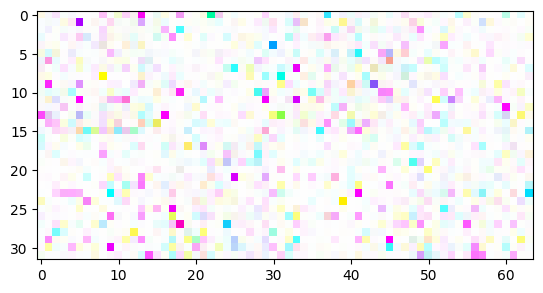

Epoch2: Discriminator Loss: 0.2625807523727417, Generator Loss: 1.6505464315414429
Epoch2: Discriminator Loss: 0.05669908970594406, Generator Loss: 1.776660680770874
Epoch2: Discriminator Loss: 0.266191303730011, Generator Loss: 2.4363181591033936
Epoch2: Discriminator Loss: 0.18196125328540802, Generator Loss: 2.451122283935547
Epoch2: Discriminator Loss: 0.19264617562294006, Generator Loss: 2.6968259811401367
Epoch2: Discriminator Loss: 0.21509432792663574, Generator Loss: 3.6386051177978516
Epoch2: Discriminator Loss: 0.15463119745254517, Generator Loss: 3.8746368885040283
Epoch2: Discriminator Loss: 0.14407317340373993, Generator Loss: 3.5750019550323486
Epoch2: Discriminator Loss: 0.3198671042919159, Generator Loss: 3.8713266849517822
Epoch2: Discriminator Loss: 0.1392626315355301, Generator Loss: 2.7197611331939697
Epoch2: Discriminator Loss: 0.079063780605793, Generator Loss: 3.243096351623535
Epoch2: Discriminator Loss: 0.09955596923828125, Generator Loss: 3.2999610900878906
Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch11: Discriminator Loss: 0.0003910944506060332, Generator Loss: 8.038490295410156
Epoch11: Discriminator Loss: 8.632614481030032e-05, Generator Loss: 8.452141761779785


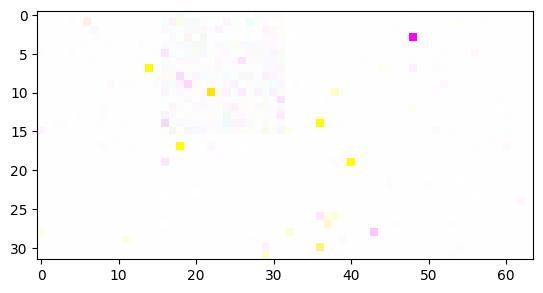

Epoch12: Discriminator Loss: 0.00013072816364001483, Generator Loss: 11.010543823242188
Epoch12: Discriminator Loss: 1.901666291814763e-05, Generator Loss: 10.673971176147461
Epoch12: Discriminator Loss: 0.0025756168179214, Generator Loss: 7.964746952056885
Epoch12: Discriminator Loss: 0.00015113562403712422, Generator Loss: 7.268825054168701
Epoch12: Discriminator Loss: 4.637638994609006e-05, Generator Loss: 9.000435829162598
Epoch12: Discriminator Loss: 0.0037465179339051247, Generator Loss: 8.857315063476562
Epoch12: Discriminator Loss: 0.0008505971054546535, Generator Loss: 8.762633323669434
Epoch12: Discriminator Loss: 4.769119914271869e-05, Generator Loss: 8.134629249572754
Epoch12: Discriminator Loss: 7.873919093981385e-05, Generator Loss: 7.797769069671631
Epoch12: Discriminator Loss: 7.835146243451163e-05, Generator Loss: 9.08515453338623
Epoch12: Discriminator Loss: 0.002586166840046644, Generator Loss: 7.41374397277832
Epoch12: Discriminator Loss: 5.4782496590632945e-05, Gen

KeyboardInterrupt: 

In [13]:
# Implementing GANs

for epoch in range(epochs):

    
    for real_img, real_label in dl:

        # if (real_img.squeeze().float().shape[0] != 16 and real_img.squeeze().float().shape[1] != 3):
        #     continue

        # print(f" Real Image shape: {real_img.squeeze().shape}, Fake Image shape: {fake_img.shape}")
        #print("Fake image shape: ", fake_img.shape)
        #print(f"Here D: {discriminator(fake_img).squeeze()}: 1: {torch.tensor(1)}")
        #print(f"Here D: {discriminator(real_img.float()).squeeze()}: 1: {torch.tensor(1)}")

        #Generator
        optimizer_G.zero_grad()
        noise = torch.randn(1, 256)
        fake_img = generator(noise)
        fake_label = 0
        loss_G = loss_fn(discriminator(fake_img).squeeze(), torch.tensor(1).float())
        loss_G.backward()
        optimizer_G.step()


        #Discriminator
        optimizer_D.zero_grad()
        fake_loss = loss_fn(discriminator(fake_img.detach()).squeeze(), torch.tensor(0).float())
        real_loss = loss_fn(discriminator(real_img).mean().squeeze(), torch.tensor(1).float())
        loss_D = (fake_loss+real_loss)/2
        loss_D.backward()
        optimizer_D.step()

        gen_loss = loss_G.item()
        print(f"Epoch{epoch+1}: Discriminator Loss: {loss_D.item()}, Generator Loss: {gen_loss}")
        
        gen_loss = int(gen_loss)
        

    
    
    if epoch%10 == 0:
        noise = torch.randn(1, 256)
        fake_img = generator(noise)
        torchvision.utils.save_image(fake_img, 'generated.jpg')
        plt.imshow(fake_img.squeeze().detach().permute(1, 2, 0))
        plt.show()
        torch.save(generator.state_dict(), 'model.pt')

    if gen_loss > 100:
        break


In [ ]:
noise = torch.randn(1, 256)
fake_img = generator(noise)
print(fake_img.shape)
torchvision.utils.save_image(fake_img, 'generated.jpg')
fake_img = fake_img.squeeze().detach().permute(1, 2, 0)

plt.imshow(fake_img)
print(fake_img.shape)
